# Introduction: Data set and background information

## About the data set

**Our data set: Estimation of obesity levels based on eating habits and physical condition in individuals from Colombia, Peru, and Mexico**

We have chosen to explore the ObesityDataSet, which is a data set of survey responses of individuals physical activity and eating habits. Below is the list of information collected

1. What is your gender? (Male/Female)
2. What is your age?
3. What is your height (in meters)?
4. What is your weight (in kilograms)?
5. Has a family member suffered or suffers from overweight? (Yes/No)
6. Do you eat high caloric food frequently? (Yes/No)
7. Do you usually eat vegetables in your meals? (Never/Sometimes/Always)
8. How many main meals do you have daily? (1-2, 3, 3+)
9. Do you eat any food between meals? (No/Sometimes/Frequently/Always)
10. Do you smoke? (Yes/No)
11. How much water do you drink daily (in liters)? (<1L, 1-2L, >2L)
12. Do you monitor the calories you eat daily? (Yes/No)
13. How often do you have physical activity (days)? (0, 1-2, 2-4, 4-5)
14. How much time do you use technological devices such as cell phone, videogames, television, computer, and others (hours)? (0-2, 3-5, >5)
15. How often do you drink alcohol? (Do not drink/Sometimes/Frequently/Always)
16. Which transportation do you usually use? (Automobile/Motorbike/Bike/Public Transportation/Walking)
17. **Obesity Level Category** ${^{[1]}}$

*From Palechor & Manotas (2019)*

[1] Obesity Level Category is a *calculated* field of the data.

Obesity level category was calculated using BMI
<br>
$BMI = \frac{weight}{height^{2}} $
<br>
The authors compared the BMI to WHO data and Mexican Normativity to classify the weight groups:
- Underweight Less than 18.5
- Normal 18.5 to 24.9
- Overweight 25.0 to 29.9
- Obesity I 30.0 to 34.9
- Obesity II 35.0 to 39.9
- Obesity III Higher than 40

*From Palechor & Manotas (2019)*

### Notes on the values

The data set consists of 17 columns. We have lists the column name and its corresponding question from above:


In [ ]:
library(kableExtra)
questions <- c(seq(from = 1, to = 16))
variables <- c("Gender", "Age", "Height", "Weight", "family_history_with_overweight", 
               "FAVC", "FCVC", "NCP", "CAEC", "SMOKE", "CH2O", "SCC", "FAF", "TUE",
               "CALC", "MTRANS")
values <- c("Female or Male", "double: ages 14-61", "double: in m", "double: in kg", "yes or no", 
            "1 = never, 2 = sometimes, 3 = always", "1-4 meals", "1 = no, 2 = sometimes, 3 = frequently, 4 = always",
            "yes or no", "1 = less than 1 liter, 2 = 1-2 liters, 3 = more than 2 liters", "yes or no", 
            "0 = none, 1 = 1-2 days, 2 = 2-4 days, 3 = 4-5 days", "0 = 0-2 hours, 1 = 3-5 hours, 2 = more than 5 hours", 
            "1 = never, 2 = sometimes, 3 = frequently, 4 = always", "automobile, motorbike, bike, public transportation, or walking",
            "Insufficient_Weight, Normal_Weight, Overweight_Level_I, Overweight_Level_II, Obesity_Type_I, Obesity_Type_II, Obesity_Type_III")
table_obesity_values <- tibble("Questions Number" = questions, "Variable Name" = variables, "Value information" = values)
table_obesity_values

### Notes about data balancing

As noted by the authors, the data set is unbalanced (Palechor & Manotas, 2019). They performed data balancing by generating synthetic data. The results are demonstrated in the Figure 1 and Figure 2.

### Figure 1: Barplot of number of records for each obesity level category of the unabalanced data set (Palechor & Manotas, 2019)

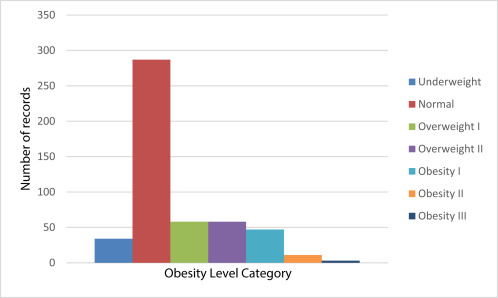

### Figure 2: Barplot of number of records for each obesity level category of the balanced data set (Palechor & Manotas, 2019)

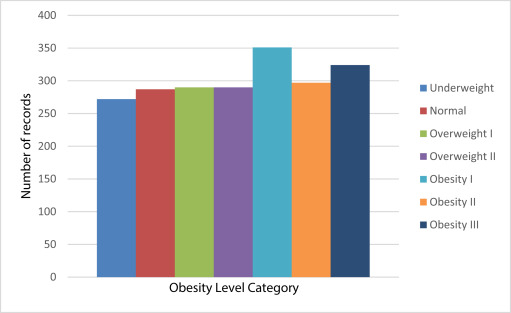

## First Look at the Data

We start by loading the libraries

In [ ]:
library(tidyverse)
library(repr)
library(tidymodels)

We then read the data into R. Note that the data was downloaded from the web and uploaded to the data folder. Data was retrieved from the UC Irvine Machine Learning Repository (https://doi.org/10.24432/C5H31Z)

In [ ]:
obesity <- read_csv("data/obesity_balanced.csv")

The default column names are not easily identifiable. We go through the labels and change them to a more suitable name. We also begin converting some of the variable from characters into factors.

In [ ]:
obesity_names <- obesity |>
    rename("obesity_level" = NObeyesdad, 
           "gender" = Gender, 
           "age" = Age, 
           "height" = Height, 
           "weight" = Weight,
           "high_caloric_freq" = FAVC, 
           "eat_veg_w_meal" = FCVC,
           "main_meals_daily" = NCP, 
           "food_btw_meals" = CAEC, 
           "smoker" = SMOKE, 
           "water" = CH2O, 
           "monitor_calories" = SCC, 
           "physical_freq" = FAF, 
           "screen_time" = TUE,
           "alcohol" = CALC, 
           "transportation_mode" = MTRANS)

obesity <- obesity |>
    mutate(CAEC = as_factor(CAEC))

obesity <- obesity |>
    mutate(Gender = as_factor(Gender))

### Preliminary Exploratory data analysis

Since we are only curious about predicting normal, overweight, and obesity, we are going to transform the data in the following ways:
1. Combine all obesity types under a single factor: obesity
2. Combine all overweight types under a single factor: overweight
2. filter out underweight as it is outside of our scope

In [ ]:
obesity_filtered <- obesity_names |>
    filter(obesity_level != "Insufficient_Weight")
obese <- c("Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III")
overweight <- c("Overweight_Level_I", "Overweight_Level_II")
obesity_mutated <- obesity_filtered |>
    mutate(obesity_level = ifelse(obesity_level %in% obese, "Obese", obesity_level)) |>
    mutate(obesity_level = ifelse(obesity_level %in% overweight, "Overweight", obesity_level)) |>
    mutate(obesity_level = as_factor(obesity_level)) |>
    mutate(bmi = (weight / (height*height))) |>
    mutate(main_meals_daily = as_factor(main_meals_daily))

glimpse(obesity_mutated)

We will now split the data into training and testing sets

In [ ]:
obesity_split <- initial_split(obesity_mutated, prop = 0.75, strata = obesity_level)
obesity_train <- training(obesity_split)
obesity_test <- testing(obesity_split)

Next, we present the data into a useful table. With our manipulations, we should see greater amount of Obese as it combined three categories).

In [ ]:
obese_summary <- obesity_train |>
    group_by(obesity_level) |>
    summarize(count = n())
obese_summary

Now we can visualize the data. We will examine smoking habits as they relate to BMI. Since we know there is a direct connection between obesity level and BMI, we can use BMI as variable to represent obesity level.

In [ ]:
obesity_and_snacking <- obesity_train |>
    ggplot(aes(x = obesity_level, fill = food_btw_meals)) +
    geom_bar(position = "fill")
obesity_and_smoking


In [ ]:
age_and_bmi <- obesity_train |>
    ggplot(aes(x = obesity_level, fill = main_meals_daily)) +
    geom_bar(position = "fill")
age_and_bmi

# References

Palechor, F. M., &amp; de la Hoz Manotas, A. (2019). Dataset for estimation of obesity levels based on eating habits and physical condition in individuals from Colombia, Peru and Mexico. *Data in Brief, 25,* 104344. https://doi.org/10.1016/j.dib.2019.104344 